In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
directorio_base = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Subir dos directorios
directorio_pkl = os.path.join(directorio_base, "src", "00.data", "clustering")

# Obtener todos los archivos .pkl en el directorio de preprocesado
archivos_pkl = [f for f in os.listdir(directorio_pkl) if f.startswith("df_clustering_") and f.endswith(".pkl")]

# Si no se encuentran archivos .pkl, mostramos un mensaje
if not archivos_pkl:
    print("❌ No se encontraron archivos .pkl en el directorio.")
else:
    df_lista = []

    # Cargar todos los archivos .pkl
    for archivo in archivos_pkl:
        ruta_archivo = os.path.join(directorio_pkl, archivo)
        try:
            with open(ruta_archivo, "rb") as f:
                df_lista.append(pickle.load(f))
                print(f"✅ Archivo cargado correctamente: {archivo}")
        except FileNotFoundError:
            print(f"❌ No se encontró el archivo: {archivo}")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

    # Concatenar todos los DataFrames en uno solo
    if df_lista:
        df = pd.concat(df_lista, ignore_index=True)
        print(f"✅ DataFrame final con {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print("❌ No se cargaron DataFrames.")

✅ Archivo cargado correctamente: df_clustering_1.pkl
✅ Archivo cargado correctamente: df_clustering_2.pkl
✅ Archivo cargado correctamente: df_clustering_3.pkl
✅ DataFrame final con 287563 filas y 10 columnas


In [5]:
df.head()

,news_id,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster_3
0,4032594,115,651,410,57,1,58,30,Política y Sociedad,1
1,4032568,77,982,362,50,2,27,24,Entretenimiento y Cultura,1
2,4032569,97,761,369,50,0,47,70,Política y Sociedad,1
3,4032482,141,505,352,77,1,64,53,Política y Sociedad,1
4,4032509,213,335,349,99,1,114,28,Política y Sociedad,1


In [6]:
df_regression = df.drop(columns=['cluster_3', 'news_id'])
df_regression.shape

(287563, 8)

In [7]:
df_filtered = df_regression[df_regression['clicks'] > 0].copy()
df_filtered.shape

(206898, 8)

In [8]:
# Filtrar outliers usando Tukey
def remove_outliers_tukey(df, columns):

    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)

    IQR = Q3 - Q1

    df_no_outliers = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_no_outliers

# Especificar las columnas numéricas que vamos a filtrar
num_features = ['meneos', 'karma', 'positive_votes', 'anonymous_votes', 'negative_votes', 'comments']

# Eliminar outliers en las columnas numéricas seleccionadas usando el método de Tukey
df_filtered_no_outliers = remove_outliers_tukey(df_filtered, num_features)

# Ver cuántas filas quedaron después de eliminar outliers
print(f'Número de filas antes de eliminar outliers: {len(df_filtered)}')
print(f'Número de filas después de eliminar outliers: {len(df_filtered_no_outliers)}')

Número de filas antes de eliminar outliers: 206898
Número de filas después de eliminar outliers: 168859


In [9]:
df_filtered['clicks'] = np.log1p(df_filtered['clicks'])

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Convertir a float32 antes de escalar
df_filtered[num_features] = df_filtered[num_features].astype('float32')

# Aplicar MinMaxScaler
regressor_scaler = MinMaxScaler()
df_filtered[num_features] = regressor_scaler.fit_transform(df_filtered[num_features])

# Guardar el escalador
regressor_scaler_path = "../00.data/clustering/regressor_scaler.pkl"

with open(regressor_scaler_path, "wb") as f:
    pickle.dump(regressor_scaler, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar OneHotEncoder a la categoría
regressor_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' evita colinealidad
encoded_cats = regressor_encoder.fit_transform(df_filtered[['category']])

# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_cats, columns=regressor_encoder.get_feature_names_out(['category']))

# Resetear índice para asegurar alineación antes de la concatenación
df_filtered = df_filtered.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Unir con el dataset original
df_filtered = pd.concat([df_filtered, encoded_df], axis=1)

# Eliminar la columna categórica original
df_filtered.drop(columns=['category'], inplace=True)

# Guardar el encoder
regressor_encoder_path = "../00.data/clustering/regressor_encoder.pkl"

with open(regressor_encoder_path, "wb") as f:
    pickle.dump(regressor_encoder, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
from sklearn.model_selection import train_test_split

# Definir X (features) e y (target)
X = df_filtered.drop(columns=['clicks'])
y = df_filtered['clicks']

# Dividir en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Invertir la transformación logarítmica si aplicaste np.log1p() a los clicks
y_pred = np.expm1(y_pred)  
y_test = np.expm1(y_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

MAE: 2871.71
MSE: 26326685.07


### Evaluar la Correlación de Features con clicks

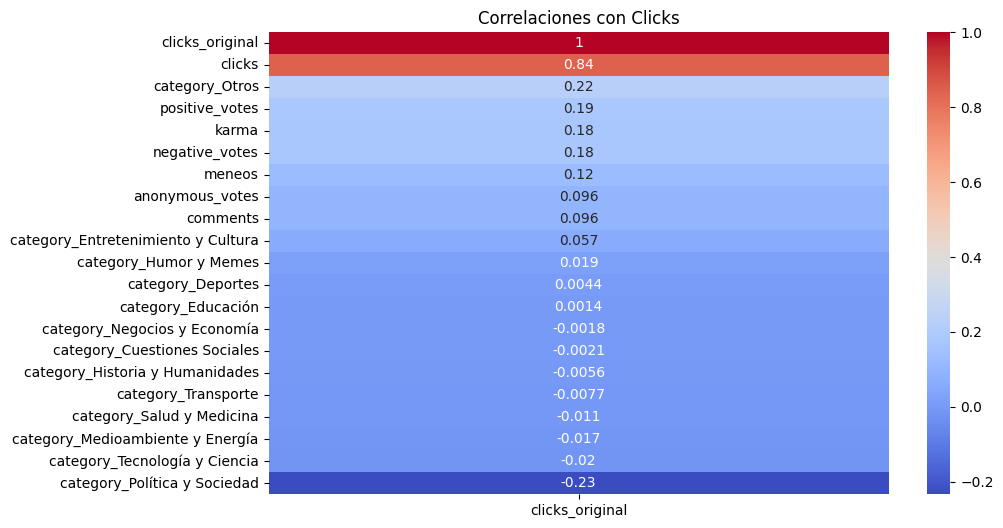

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir clicks a escala original para evaluar correlaciones
df_filtered['clicks_original'] = np.expm1(df_filtered['clicks'])

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Mostrar correlaciones con 'clicks_original'
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix[['clicks_original']].sort_values(by='clicks_original', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlaciones con Clicks')
plt.show()

### Probar con otros modelos: Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = np.expm1(rf_model.predict(X_test))  # Deshacer transformación logarítmica
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'Random Forest MAE: {mae_rf:.2f}')
print(f'Random Forest MSE: {mse_rf:.2f}')

Random Forest MAE: 2662.01
Random Forest MSE: 22447656.11


In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = np.expm1(gb_model.predict(X_test))  # Deshacer transformación logarítmica
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)

print(f'Gradient Boosting MAE: {mae_gb:.2f}')
print(f'Gradient Boosting MSE: {mse_gb:.2f}')

Gradient Boosting MAE: 2690.59
Gradient Boosting MSE: 23604200.46


### Feature Engineering

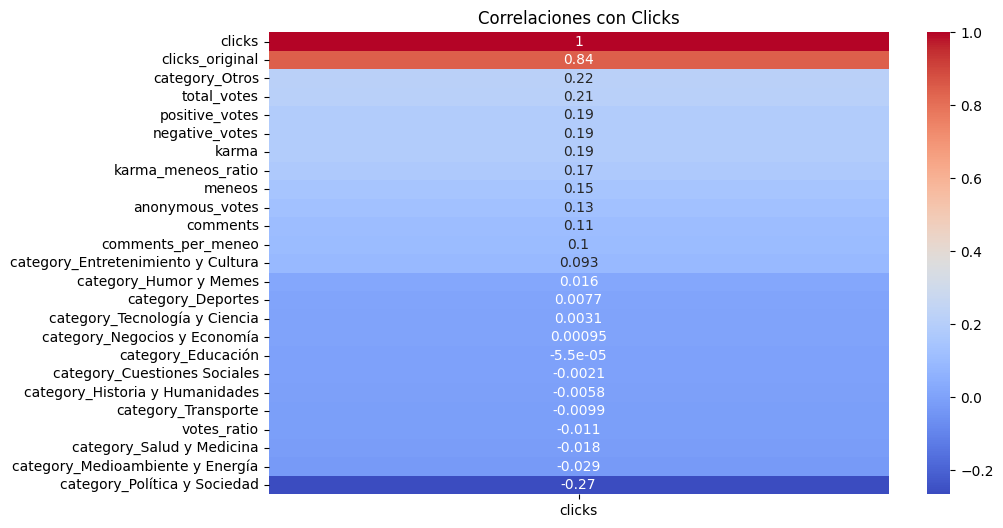

In [17]:
# Crear nuevas features
df_filtered['karma_meneos_ratio'] = df_filtered['karma'] / (df_filtered['meneos'] + 1)
df_filtered['total_votes'] = df_filtered['positive_votes'] + df_filtered['negative_votes'] + df_filtered['anonymous_votes']
df_filtered['comments_per_meneo'] = df_filtered['comments'] / (df_filtered['meneos'] + 1)
df_filtered['votes_ratio'] = (df_filtered['positive_votes'] - df_filtered['negative_votes']) / (df_filtered['total_votes'] + 1)

# Revisar correlaciones después de agregar nuevas variables
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_filtered.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix[['clicks']].sort_values(by='clicks', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlaciones con Clicks')
plt.show()

In [18]:
# Calcular correlaciones con 'clicks'
correlation_matrix = df_filtered.corr()
correlation_with_target = correlation_matrix['clicks'].abs()

# Seleccionar columnas con correlación >= 0.02 (ajustar según lo que consideres apropiado)
columns_to_keep = correlation_with_target[correlation_with_target >= 0.02].index
df_filtered = df_filtered[columns_to_keep]

In [19]:
# Definir X (features) e y (target) después de filtrar las columnas
X = df_filtered.drop(columns=['clicks'])
y = df_filtered['clicks']

# Dividir en entrenamiento y prueba (80% - 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Entrenar y evaluar el modelo RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicción y evaluación
y_pred_rf = np.expm1(rf_model.predict(X_test))  # Deshacer transformación logarítmica
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'Random Forest MAE: {mae_rf:.2f}')
print(f'Random Forest MSE: {mse_rf:.2f}')

Random Forest MAE: 4784.53
Random Forest MSE: 49262706.86


In [21]:
# Entrenar y evaluar el modelo GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predicción y evaluación
y_pred_gb = np.expm1(gb_model.predict(X_test))  # Deshacer transformación logarítmica
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)

print(f'Gradient Boosting MAE: {mae_gb:.2f}')
print(f'Gradient Boosting MSE: {mse_gb:.2f}')

Gradient Boosting MAE: 4785.15
Gradient Boosting MSE: 49700045.00


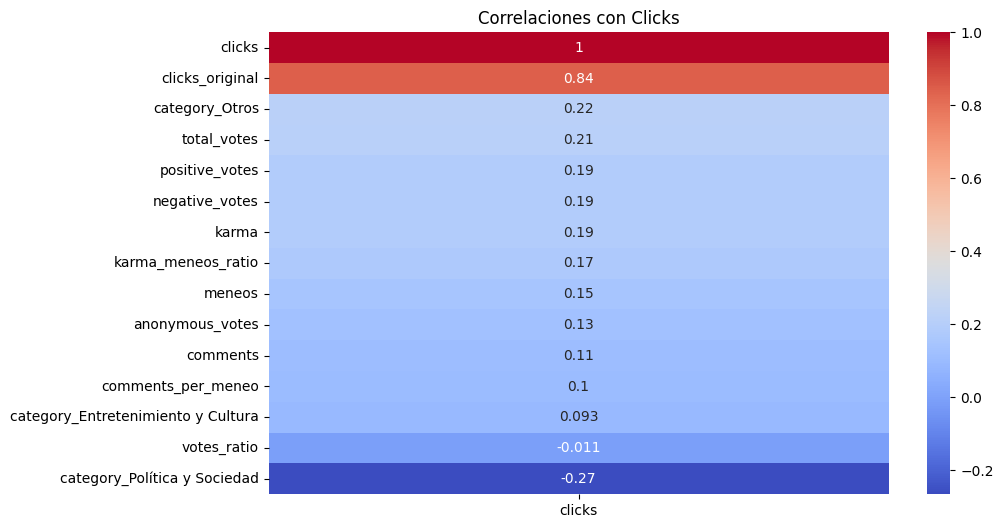

In [25]:
# Asegurarse de que las nuevas características están presentes
df_filtered['karma_meneos_ratio'] = df_filtered['karma'] / (df_filtered['meneos'] + 1)
df_filtered['total_votes'] = df_filtered['positive_votes'] + df_filtered['negative_votes'] + df_filtered['anonymous_votes']
df_filtered['comments_per_meneo'] = df_filtered['comments'] / (df_filtered['meneos'] + 1)
df_filtered['votes_ratio'] = (df_filtered['positive_votes'] - df_filtered['negative_votes']) / (df_filtered['total_votes'] + 1)

# Filtrar de nuevo después de asegurar que las nuevas características estén presentes
correlation_matrix = df_filtered.corr()
correlation_with_target = correlation_matrix['clicks'].abs()
columns_to_keep = correlation_with_target[correlation_with_target >= 0.05].index
df_filtered = df_filtered[columns_to_keep]

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix[['clicks']].sort_values(by='clicks', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlaciones con Clicks')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir el grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

# Entrenar
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_

# Evaluar modelo optimizado
y_pred_rf_opt = np.expm1(best_rf.predict(X_test))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)
mse_rf_opt = mean_squared_error(y_test, y_pred_rf_opt)

print(f'Optimized Random Forest MAE: {mae_rf_opt:.2f}')
print(f'Optimized Random Forest MSE: {mse_rf_opt:.2f}')


 Define un modelo de regresión que pueda predecir el número de clicks de una
publicación según sus características dependiendo del clustering que pertenecen. 
• Puedes usar también modelos de Redes Neuronales. En el caso de usar redes,
considera probar tanto hacer una red para cada cluster como hacer una única red y usar
el cluster como feature.
• Guarda en una tabla los resultados de los modelos para mostrarlos en Streamlit. Obtén
también predicciones del número de clicks en las publicaciones donde no aparece el
número de clicks.